In [2]:
import sys, os
from scipy import stats
import numpy as np
import pandas as pd

from scipy import stats

sys.path.insert(1, '../libs/')
from stat_lib import *

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Comparando-se o mesmo grupo duas vezes (pareado)

Vamos supor que temos um grupo de pacientes que vão ser medicados. Medimos um determinado marcador (p.ex. glicemia) antes da medicação e depois da medicação. ** Desenho experimental e cálculo de número amostral (N).

A principal pergunta: - O medicmaento fez efeito

Caso a distribuição do biomarcador seja normal, podemos fazer o teste t-student para comparar os dois grupos.

Glicose no sangue (mg/dl)
  - normal: < 99 mg/dl
  - pré-diabético: [100, 125] mg/dl
  - diabético: > 125 mg/dl

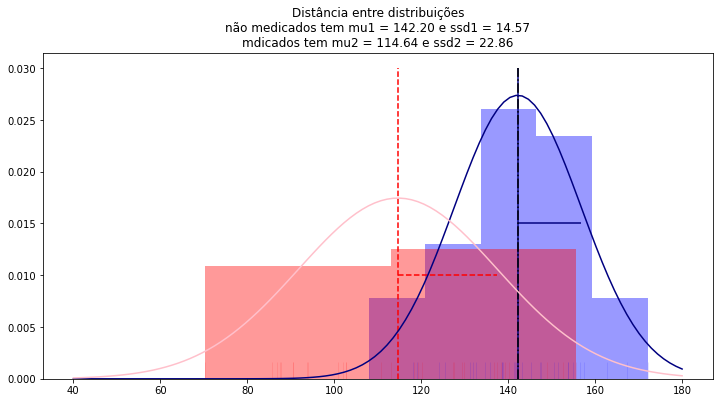

In [3]:
mu1 = 140; sdv1 = 15
mu2 = 110; sdv2 = 25
N   = 30

samp1 = np.random.normal(loc=mu1, scale=sdv1, size=N)
samp2 = np.random.normal(loc=mu2, scale=sdv2, size=N)

muc1 = np.mean(samp1); sdvc1 = np.std(samp1)
muc2 = np.mean(samp2); sdvc2 = np.std(samp2)

fig = plt.figure(figsize=(12, 6))

#-- se mesmo eixo - figuras estão sobrepostas
ax  = sns.distplot(samp1, kde=False, rug=True, norm_hist=True, color='blue', rug_kws={"color": 'blue', "alpha": .1,})
ret = sns.distplot(samp2, kde=False, rug=True, norm_hist=True, color='red',  rug_kws={"color": 'red',  "alpha": .1,}, ax=ax)

hline = 0.03

plt.vlines(muc1, 0, hline, color = 'navy')
plt.hlines(.015, muc1, muc1+sdvc1, color = 'navy');

plt.vlines(muc2, 0, hline, color = 'red', linestyle='--')
plt.hlines(.010, muc2, muc2+sdvc2, color = 'red', linestyle='--')

plt.vlines(muc1, 0, hline, color = 'black', linestyle='-.')

#--- fitando a distribuição normal com muc e sdvc
#---                          Percent Point Function (PPF)
# seqx = np.linspace(mu1-4*sdv1, mu2+4*sdv2, 100)
seqx = np.linspace(40, 180, 100)
sns.lineplot(seqx, stats.norm.pdf(seqx, muc1, sdvc1), color='navy')
sns.lineplot(seqx, stats.norm.pdf(seqx, muc2, sdvc2), color='pink')

title = 'Distância entre distribuições'
title += '\nnão medicados tem mu1 = %.2f e ssd1 = %.2f'%(muc1, sdvc1)
title += '\nmdicados tem mu2 = %.2f e ssd2 = %.2f'%(muc2, sdvc2)
plt.title(title);

In [4]:
mu1, mu2

(140, 110)

In [5]:
muc1, muc2

(142.19686641535185, 114.64185973838858)

### As distribuições são nomais? teste de Shaprio-Wilkis

In [6]:
def stat_asteristics(pval, NS='NS'):
    if pval >= 0.05:   return NS
    if pval > 0.01:    return '*'
    if pval > 0.001:   return '**'
    if pval > 0.0001:  return '***'
    return '****'

def test_normality_desc(series, alpha = 0.05, NS='NS'):
    # teste de normalidade de Shapiro-Wilkis
    stat, pvalue = stats.shapiro(series)

    if pvalue > alpha:
        text = 'A distribuição se assemelha a uma distribuição normal (não se rejeita a H0)'
        ret = True
    else:
        text = 'A distribuição não se assemelha a uma distribuição normal (rejeita-se a H0)'
        ret = False

    text_stat = 'p-value %.2e (%s)'%(pvalue, stat_asteristics(pvalue, NS))

    return ret, text, text_stat, stat, pvalue

### Para controle

In [7]:
ret1, text1, text_stat1, stat1, pvalue1 = test_normality_desc(samp1, 0.05, NS='---')
text1, text_stat1

('A distribuição se assemelha a uma distribuição normal (não se rejeita a H0)',
 'p-value 9.97e-01 (---)')

### Para tratado

In [8]:
ret2, text2, text_stat2, stat2, pvalue2 = test_normality_desc(samp2, 0.05, NS='---')
text2, text_stat2

('A distribuição se assemelha a uma distribuição normal (não se rejeita a H0)',
 'p-value 2.45e-01 (---)')

### As variâncias iguais?

In [9]:
np.round(sdvc1,1), np.round(sdvc2,1)

(14.6, 22.9)

## ERRATA
  - para setar equal_var não utilizamos ANOVA
  - para saber se SSDs são diferentes podemos usar t-test também
    - t-test(SSD1, SSD2)
    - caso os valores pontuais se expressem em distribuições normais
    - todo parâmetro tem uma média e um desvio padrão TAMBÉM !!! complicado?

### Teste-t

**equal-var** 
If True (default), perform a standard independent 2 sample test that assumes equal population variances [1]. 
If False, perform Welch’s t-test, which does not assume equal population variance [2].

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [10]:
def ttest(samp1, samp2, alpha = 0.05, equal_var=False):

    stat, pvalue = stats.ttest_ind(samp1, samp2, equal_var = equal_var)

    if pvalue > alpha:
        text = 'As distribuições são similares (não se rejeita a H0)'
        ret = True
    else:
        text = 'As distribuições não são similares (rejeita-se a H0)'
        ret = False

    text_stat = 'p-value %.2e (%s)'%(pvalue, stat_asteristics(pvalue))

    return ret, text, text_stat, stat, pvalue

In [11]:
ret, text, text_stat, stat, pvalue = ttest(samp1, samp2, equal_var=False)
text, text_stat

('As distribuições não são similares (rejeita-se a H0)',
 'p-value 1.48e-06 (****)')

### Como entendemos este resultado?

  - Controle: pacientes não medicados
  - Case:     pacientes medicados
  
  
  - Se distriuições similares (t-test, diferença próxima a zero - e o intervalo de confiança passa pelo zero) significa que a droga não fez efeito
  - Se distriuições distantes (t-test, intervalo de confiança (IC) longe do zero) significa que a droga fez efeito
    - ter um efeito DESASTROSO, neste caso, se a diferença for positiva
    - ter um efeito BENÉFICO  , neste caso, se a diferença for negativa
  

### O quão distante estão as distribuições???

  - Vamos calcular:
    - Intervalo de confiança
    - Tamanho do efeito (effect size)
    - A diferença entre as médias
    - Mostrar como se apresenta estes resultados

### Relembrando conceitos

#### Teste t

statistician William Sealy Gosset 

<font size="6">t-stat = $\frac{<X>-\mu}{\frac{SSD}{\sqrt(n)}}$</font>

de forma mais generalizada dadas duas distribuições X1 e X2

<font size="6">t-stat = $\frac{<X1>-<X2>}{\sqrt( \frac{var1}{n1} + \frac{var2}{n2}) }$</font>


#### Tamanho do efeito (effect size)

<font size="5">$\theta = \frac{media_1 - media_2}{SSD}$</font>

https://en.wikipedia.org/wiki/Effect_size


#### Distância entre médias

<font size="5">$diff = media_1 - media_2$</font>


#### SEM

<font size="5">$SEM = \frac{SSD}{\sqrt{n}}$</font>


### Intervalo de confiança (confidence interval CI)

<font size="5">$CI = [mean - \gamma_{inf} * SEM, mean + \gamma_{sup} * SEM]$</font>

onde $\gamma$ é a cumulativa da distribuição paa uma dada probabilidade (p.ex. 95% confiança alpha = .025 para esquerda e 0.025 para a direita, quando bicaudal.


  - ***Desafio*** - nosso estudo é bicaudal??


In [12]:
#-- função fi --> calcula o Gamma que um fator de "confiança" (~95%) da estatística
# disribuição bi-caudal --> correto - intervalo de confiança

# confiança é de 95% --> alpha = 0.05
# confiança é de 99% --> alpha = 0.01

def calc_fi(dof, is_normal=False, alpha=.05):
    
    alpha /= 2
    if is_normal:
        fi_inf = stats.norm.ppf(alpha, 0, 1)
        fi_sup = stats.norm.ppf(1-alpha, 0, 1)
    else:
        fi_inf = stats.t.ppf( alpha, dof)
        fi_sup = stats.t.ppf( (1-alpha), dof)

    return np.array( [fi_inf, fi_sup])

# samp1 = controle
# samp2 = case
def calc_intervalo_confianca(samp1, samp2, alpha=.05):
    
    n1 = len(samp1); n2 = len(samp2)
    if n1 >= n2:
        N = n1
    else:
        N = n2
    dof = N-1

    x = np.linspace(stats.t.ppf(0.01, dof), stats.t.ppf(0.99, dof), 100)
    
    muc1 = np.mean(samp1); sdvc1 = np.std(samp1)
    muc2 = np.mean(samp2); sdvc2 = np.std(samp2)

    diff = muc2 - muc1
    sd_diff = np.sqrt(sdvc1**2 + sdvc2**2)
    
    effect_size = diff / sd_diff

    # simulação
    # gammas [-1.96, +1.96]
    # gammas * SEM = [-1.96, +1.96] * 2 --> ~[-4 , 4]
    # IC = diff + gamas * SEM --> 3 + ~[-4 , 4] --> [-1, 7]
    # como não passa pelo zero --> p-value < 0.05
    gammas = calc_fi(dof, alpha=alpha, is_normal=False)
    SEM = np.sqrt(sdvc1**2/n1 + sdvc2**2/n2)
    CI = (gammas * SEM) + diff
    
    return CI, SEM, n1, n2, effect_size, diff



In [13]:
alpha=.05

CI, SEM, n1, n2, effect_size, diff = calc_intervalo_confianca(samp1, samp2, alpha=alpha)
list(np.round(CI,2)), np.mean(list(np.round(CI,2)))

([-37.68, -17.43], -27.555)

In [14]:
n1, n2, np.round(effect_size,2), np.round(diff,2)

(30, 30, -1.02, -27.56)

### Perguntas

  - Porque a diferença deu negativa?
  - Porque o Tamanho de Efeito é menor que a diferença?
  - O que significa os valores do intervalo de confiança?


### Como devo apresentar meus resultados?

In [15]:
print("Pacientes (n=%d) controle apresentaram média de glicemia de %.2f (%.2f) mg/dl e após tratamento a mesma foi para %.2f (%.2f) mg/dl" %(N, muc1, sdvc1, muc2, sdvc2 ))
print("O intervalo de confiança, para um coeficiente de confiança de %.1f%%, foi de [%.2f, %.2f] mg/dl"%( 100*(1-alpha), CI[0], CI[1]))
print("Utilizando-se t-test, com variâncias diferentes, o p-value calculado foi de %.1e%% o que indica um efeito positivo do medicamento."%(pvalue))
print("Uma vez que o tamanho do efeito foi de %.2f mg/dl e a diferença das medias foi de %.2f mg/dl, apresentando uma diminuição na glicemia pós-tratamento"%(effect_size, diff))

Pacientes (n=30) controle apresentaram média de glicemia de 142.20 (14.57) mg/dl e após tratamento a mesma foi para 114.64 (22.86) mg/dl
O intervalo de confiança, para um coeficiente de confiança de 95.0%, foi de [-37.68, -17.43] mg/dl
Utilizando-se t-test, com variâncias diferentes, o p-value calculado foi de 1.5e-06% o que indica um efeito positivo do medicamento.
Uma vez que o tamanho do efeito foi de -1.02 mg/dl e a diferença das medias foi de -27.56 mg/dl, apresentando uma diminuição na glicemia pós-tratamento


### Exercício:

  - Crie 2 grupos
    - 30 homens
    - 30 mulheres
    
  - Simule as glicemias e os resultados dos tratamentos
  - Compare homens x mulheres:
    - Antes do tratamento
    - Depois do tratamento
  - Compare todos os pacientes:
    - Antes x Depois do tratamento
  - Compare somente mulheres (depois somente homens):
    - Antes x Depois do tratamento
  - Análise seus resultados
  - Descreva seus resultados
 
 
#### Pergunta:

  - O que fizemos de diferente com relação ao estudo anterior?
    - a diferença é MÚLTIPLAS COMPARAÇÕES
  - Posso comparar todos os pacientes antes e depois do tratamento? - independente de sexo (gênero)
    - Responder: **desafio**  

In [16]:
Nh = 30; Nm = 28

#-- media de homens antes do tratamento (controle) e depois do tratamento
muha = 140; sdha = 15
muhd = 110; sdhd = 25

muma = 155; sdma = 13
mumd = 121; sdmd = 18

sampha = np.random.normal(loc=muha, scale=sdha, size=Nh)
samphd = np.random.normal(loc=muhd, scale=sdhd, size=Nh)

sampma = np.random.normal(loc=muma, scale=sdma, size=Nm)
sampmd = np.random.normal(loc=mumd, scale=sdmd, size=Nm)

In [17]:
np.round(np.mean(sampha),2), np.round(np.mean(samphd),2)

(139.7, 114.99)

In [18]:
np.round(np.mean(sampma),2), np.round(np.mean(sampmd),2)

(150.55, 119.69)